In [13]:
import pandas as pd 
from sklearn.model_selection import train_test_split
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from sklearn.preprocessing import LabelEncoder



In [14]:
data = pd.read_csv("handgesture.txt", header=None)
data.to_csv("handgesture_copy.txt", index=False, header=False)


features = data.iloc[:, :-1].values
data.iloc[:, -1] = data.iloc[:, -1].astype(str)
labels = data.iloc[:, -1].values


le = LabelEncoder()
labels = le.fit_transform(labels)

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

In [15]:

class GestureCNN(nn.Module):
    def __init__(self):
        super(GestureCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(16 * 6 * 6, 64)
        self.fc2 = nn.Linear(64, 3)  # 3 output classes: c, h, 2

    def forward(self, x):
        x = F.relu(self.conv1(x))   # [B, 8, 6, 6]
        x = F.relu(self.conv2(x))   # [B, 16, 6, 6]
        x = x.view(x.size(0), -1)   # flatten
        x = F.relu(self.fc1(x))
        return self.fc2(x)

In [16]:

class GestureDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32).reshape(-1, 1, 6, 6)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [17]:
print(type(X_train))
print(X_train.dtype)
print(X_train.shape)
print(X_train[0])  # Inspect a single element


<class 'numpy.ndarray'>
float64
(100, 36)
[0.58940397 0.24006623 0.99503311 0.99834437 0.99834437 1.
 0.5397351  1.         0.99668874 1.         0.99834437 1.
 0.30463576 0.86754967 0.99834437 0.         0.99834437 1.
 0.6589404  0.98675497 0.99834437 0.99834437 1.         1.
 0.78476821 0.53642384 0.34271523 0.89238411 0.00496689 0.62582781
 0.58443709 0.0115894  0.         0.17715232 0.99834437 1.        ]


In [18]:
from torch.utils.data import DataLoader

train_dataset = GestureDataset(X_train, y_train)
test_dataset = GestureDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)


In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GestureCNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

# Training loop
for epoch in range(20):
    model.train()
    total_loss = 0
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)

        optimizer.zero_grad()
        out = model(batch_x)
        loss = loss_fn(out, batch_y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")


Epoch 1, Loss: 4.3142
Epoch 2, Loss: 4.2523
Epoch 3, Loss: 4.0504
Epoch 4, Loss: 4.1313
Epoch 5, Loss: 4.0361
Epoch 6, Loss: 3.7742
Epoch 7, Loss: 3.5429
Epoch 8, Loss: 3.5335
Epoch 9, Loss: 3.0486
Epoch 10, Loss: 2.9233
Epoch 11, Loss: 2.7763
Epoch 12, Loss: 2.5768
Epoch 13, Loss: 2.4575
Epoch 14, Loss: 2.3601
Epoch 15, Loss: 2.1867
Epoch 16, Loss: 2.1026
Epoch 17, Loss: 1.9177
Epoch 18, Loss: 2.0494
Epoch 19, Loss: 1.6943
Epoch 20, Loss: 2.1402


In [20]:
model.eval()
correct = total = 0
with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        pred = model(batch_x).argmax(dim=1)
        correct += (pred == batch_y).sum().item()
        total += batch_y.size(0)

print(f"Test Accuracy: {correct / total:.2%}")


Test Accuracy: 84.62%


In [21]:
def predict(image_array):
    image_tensor = torch.tensor(image_array, dtype=torch.float32).reshape(1, 1, 6, 6).to(device)
    model.eval()
    with torch.no_grad():
        out = model(image_tensor)
        pred_class = out.argmax(dim=1).item()
    return le.inverse_transform([pred_class])[0]


In [22]:
# input_vector = np.array(

# [1.0, 1.0, 0.7305785123966942, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.456198347107438, 1.0, 1.0, 0.0, 1.0, 0.7900826446280992, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0]

# )

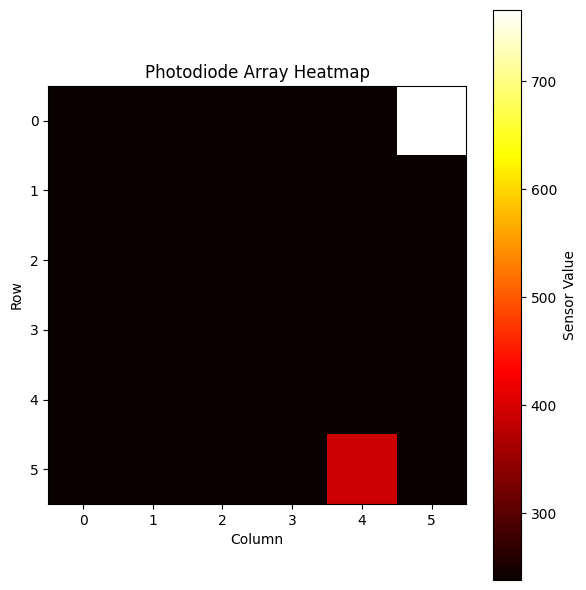

' 2'

In [74]:
import serial
import time
import matplotlib.pyplot as plt
import numpy as np

ser = serial.Serial('/dev/cu.usbmodem11301', 115200)
time.sleep(2) 

ser.write(b'START\n')
matrix = []

while len(matrix) < 36:
    line = ser.readline().decode().strip()
    # print(f"rec: {line}")
    try:
        values = list(map(int, line.split()))
        matrix.extend(values)
        # print(matrix)
    except ValueError:
        print(f"cant parse '{line}'")
ser.close()
matrix = np.array(matrix).reshape((6, 6))

plt.figure(figsize=(6, 6))
plt.imshow(matrix, cmap='hot', interpolation='nearest')
plt.colorbar(label='Sensor Value')
plt.title("Photodiode Array Heatmap")
plt.xlabel("Column")
plt.ylabel("Row")
plt.tight_layout()
plt.show()

normalized_matrix = (matrix - np.min(matrix)) / (np.max(matrix) - np.min(matrix))
flat_list = normalized_matrix.flatten().tolist()

# print(flat_list)


agh = np.array(flat_list)
predict(agh)
            

In [ ]:
agh = np.array(flat_list)
predict(agh)

In [26]:
training = False
label = 2
if training:
    with open('handgesture.txt', 'a') as f:
        f.write(', '.join(map(str, flat_list)))
        f.write(f', {label}\n') 

            